In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
df.drop(columns='time', inplace=True)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,0


In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,1.00000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


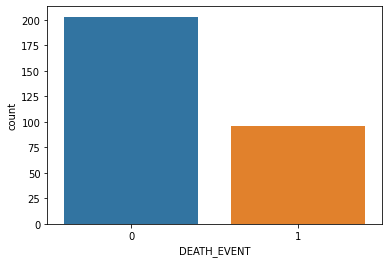

In [ ]:
sns.countplot(x=df['DEATH_EVENT']); #Poucas entradas com o valor '1'. Irá afetar os algoritimos no momento de reconhecer pacientes que morreram.

In [ ]:
df.corr()['DEATH_EVENT'].sort_values(ascending=False)

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
Name: DEATH_EVENT, dtype: float64

##Tratamento dos outliers

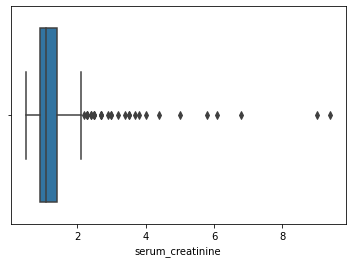

In [ ]:
sns.boxplot(x=df['serum_creatinine']);

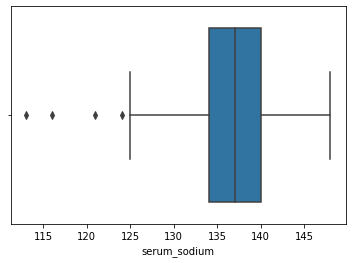

In [ ]:
sns.boxplot(x=df['serum_sodium']);

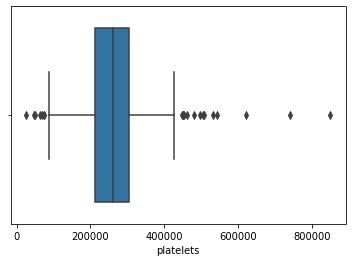

In [ ]:
sns.boxplot(x=df['platelets']);

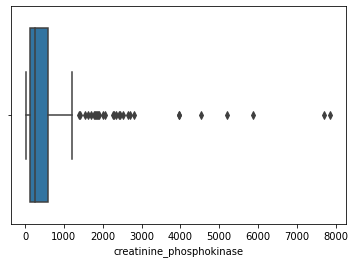

In [ ]:
sns.boxplot(x=df['creatinine_phosphokinase']);

Os gráficos acusam inúmeros outliers, entretanto não há necessidade de removê-los ou tratá-los, pois é possível que uma pessoa alcance essa quantidade nos exames. Ademais, esses outliers acompanham uma grande influência na nossa variável "target" DEATH_EVENT. 

##Sobreamostragem com SMOTE - Tratamento dos dados desbalanceados

Recentemente estudei sobre classes desbalanceadas e como solucioná-las e descobri que o SMOTE não é uma boa solução, mas visto que ainda não me aprofundei sobre o assunto e é o único que conheço, utilizei-o assim mesmo.

In [ ]:
from imblearn.over_sampling import SMOTE

X, y = df.drop(columns='DEATH_EVENT'), df['DEATH_EVENT'].copy()

smote = SMOTE(sampling_strategy = 'minority')
X_over, y_over = smote.fit_resample(X, y)

In [ ]:
X.shape, X_over.shape, y.shape, y_over.shape #Aumento de entradas

((299, 11), (406, 11), (299,), (406,))

In [ ]:
np.unique(y, return_counts=True), np.unique(y_over, return_counts=True) #Dados balanceados

((array([0, 1]), array([203,  96])), (array([0, 1]), array([203, 203])))

##Divisão entre treinamento e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.1)

##Aplicando algoritimos

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [ ]:
svm_pipe = Pipeline([
                     ('scaler', StandardScaler()),
                     ('svm', SVC())
])

log_pipe = Pipeline([
                     ('scaler', StandardScaler()),
                     ('log_clf', LogisticRegression())
])

tree_clf = DecisionTreeClassifier(min_samples_leaf=5)
random_clf = RandomForestClassifier(max_leaf_nodes=12)


In [ ]:
svm_pipe.fit(X_train, y_train)
log_pipe.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)
random_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=12)

In [ ]:
prev_svm = svm_pipe.predict(X_test)
prev_tree = tree_clf.predict(X_test)
prev_log = log_pipe.predict(X_test)
prev_random = random_clf.predict(X_test)

In [ ]:
for clf, label in zip([prev_svm, prev_tree, prev_log, prev_random], ['SVM', 'Decision Tree', 'Logistic Regression', 'Random Forest']):
  print(f'{label}:\n {classification_report(y_test, clf)}')

SVM:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.78      0.78      0.78        18

    accuracy                           0.80        41
   macro avg       0.80      0.80      0.80        41
weighted avg       0.80      0.80      0.80        41

Decision Tree:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       0.80      0.89      0.84        18

    accuracy                           0.85        41
   macro avg       0.85      0.86      0.85        41
weighted avg       0.86      0.85      0.85        41

Logistic Regression:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82        23
           1       0.80      0.67      0.73        18

    accuracy                           0.78        41
   macro avg       0.78      0.77      0.77        41
weighted avg       0.78      0

##Tuning dos parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_tree = [
             {'max_depth': [None, 1, 3, 5, 7], 'min_samples_split': [2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 5, 10]}
]

param_random = [
                {'n_estimators': [50, 100, 125], 'max_depth': [None, 1, 3, 5, 7], 'min_samples_split': [2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 5, 10]}
]

param_svc = [
             {'C': [1, 5, 10], 'kernel': ['linear', 'poly', 'rbf'],}
]

param_log = [
             {'C': [1, 5, 10]},
             {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [1, 5, 10]},
             {'solver': ['saga'], 'penalty': ['elasticnet'], 'l1_ratio': [0.5], 'C': [1, 5, 10]}
]

In [ ]:
scaler = StandardScaler()
svm_clf = SVC()
tree_clf = DecisionTreeClassifier()
random_clf = RandomForestClassifier()
log_clf = LogisticRegression()

grid_svm = GridSearchCV(svm_clf, param_svc, cv=5, scoring='accuracy')
grid_tree = GridSearchCV(tree_clf, param_tree, cv=5, scoring='accuracy')
grid_random = GridSearchCV(random_clf, param_random, cv=5, scoring='accuracy')
grid_log = GridSearchCV(log_clf, param_log, cv=5, scoring='accuracy')

In [ ]:
grid_svm.fit(scaler.fit_transform(X_train), y_train)
grid_tree.fit(X_train, y_train)
grid_random.fit(X_train, y_train)
grid_log.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [1, 5, 10]},
                         {'C': [1, 5, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [1, 5, 10], 'l1_ratio': [0.5],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy')

In [ ]:
#Melhores parâmetros para seus respectivos modelos
for clf in [grid_svm, grid_tree, grid_random, grid_log]:
  print(f'{clf.estimator}: {clf.best_params_}')

SVC(): {'C': 1, 'kernel': 'linear'}
DecisionTreeClassifier(): {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10}
RandomForestClassifier(): {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
LogisticRegression(): {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
for grid_clf in [grid_svm, grid_log, grid_tree, grid_random]:
  if grid_clf is grid_svm or grid_clf is grid_log:
    prev = grid_clf.predict(scaler.transform(X_test))
    print(f'{grid_clf.estimator}:\n {classification_report(y_test, prev)}')
  else:
    prev = grid_clf.predict(X_test)
    print(f'{grid_clf.estimator}:\n {classification_report(y_test, prev)}')

SVC():
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.81      0.72      0.76        18

    accuracy                           0.80        41
   macro avg       0.81      0.80      0.80        41
weighted avg       0.81      0.80      0.80        41

LogisticRegression():
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.81      0.72      0.76        18

    accuracy                           0.80        41
   macro avg       0.81      0.80      0.80        41
weighted avg       0.81      0.80      0.80        41

DecisionTreeClassifier():
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        23
           1       0.79      0.83      0.81        18

    accuracy                           0.83        41
   macro avg       0.83      0.83      0.83        41
weighted avg    

##Combinação dos modelos com VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
grid_svm.best_params_

{'C': 1, 'kernel': 'linear'}

In [ ]:
voting_soft = VotingClassifier(
    estimators=[('lr', grid_log.best_estimator_), ('rf', grid_random.best_estimator_), ('dt', grid_tree.best_estimator_), 
                ('svm', SVC(kernel='linear', probability=True))], voting='soft')

voting_hard = VotingClassifier(
    estimators=[('lr', grid_log.best_estimator_), ('rf', grid_random.best_estimator_), ('dt', grid_tree.best_estimator_), 
                ('svm', grid_svm.best_estimator_)], voting='hard')

voting_soft.fit(scaler.fit_transform(X_train), y_train)
voting_hard.fit(scaler.fit_transform(X_train), y_train)

y_pred_soft = voting_soft.predict(scaler.transform(X_test))
y_pred_hard = voting_hard.predict(scaler.transform(X_test))

print(f'Soft: \n{classification_report(y_test, y_pred_soft)}')
print(f'Hard: \n{classification_report(y_test, y_pred_hard)}')

Soft: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.83      0.83      0.83        18

    accuracy                           0.85        41
   macro avg       0.85      0.85      0.85        41
weighted avg       0.85      0.85      0.85        41

Hard: 
              precision    recall  f1-score   support

           0       0.79      0.96      0.86        23
           1       0.92      0.67      0.77        18

    accuracy                           0.83        41
   macro avg       0.85      0.81      0.82        41
weighted avg       0.85      0.83      0.82        41



Modelo "Soft" com maior acurácia e, mais importante, F1-score melhor que o "Hard".

In [ ]:
from sklearn.metrics import accuracy_score
for clf, label in zip([grid_log, grid_random, grid_tree, grid_svm, voting_hard, voting_soft], ['Log', 'Random', 'Tree', 'SVM', 'Hard', 'Soft']):
  if clf is grid_svm or clf is grid_log or clf is voting_hard or clf is voting_soft:
    prev = clf.predict(scaler.transform(X_test))
  else:
    prev = clf.predict(X_test)
  print(label, accuracy_score(y_test, prev))

Log 0.8048780487804879
Random 0.8292682926829268
Tree 0.8292682926829268
SVM 0.8048780487804879
Hard 0.8292682926829268
Soft 0.8536585365853658


In [ ]:
final_model = Pipeline([
                        ('scaler', scaler),
                        ('voting', voting_soft)
])

##Salvando Modelo

In [ ]:
import joblib

In [ ]:
joblib.dump(final_model, 'heart_failure_model.pkl')

['heart_failure_model.pkl']